In [ ]:
!pip install Bio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 321.3/321.3 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 40.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.7/46.7 kB 1.8 MB/s eta 0:00:00


[1/6] Building label_map from NDARO files...
[OK] Wrote label_map.csv  rows=10850
[2/6] Building seq_manifest.csv from FASTA...
[DEBUG] Sample FASTA headers (first 5):
  0|AAA16360.1|L11078.1|1|1|stxA2b|stxA2b|Shiga_toxin_Stx2b_subunit_A L11078.1:177-1136
  0|AAA16361.1|L11078.1|1|1|stxB2b|stxB2b|Shiga_toxin_Stx2b_subunit_B L11078.1:1149-1412
  0|AAA16362.1|L11079.1|1|1|stxA2c|stxA2c|Shiga_toxin_Stx2c_subunit_A L11079.1:177-1136
  0|AAA18472.1|U09235.1|1|1|ystA|ystA|ST-I_family_heat-stable_enterotoxin_YstA U09235.1:1089-1304
  0|AAA18786.1|U04208.1|1|1|cdtB_II|cdtB_II|cytolethal_distending_toxin_type_II_nuclease_subunit_CdtB U04208.1:1181-1990
[DEBUG] Extracted 9327 sequences from FASTA
[DEBUG] label_map alleles (first 10): [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]
[DEBUG] FASTA alleles (first 10): ['stxA2b', 'stxB2b', 'stxA2c', 'ystA', 'cdtB_II', 'stxA2e', 'stxB2e', 'stxA2_acd', 'seh', 'astA']
[DEBUG] Alleles in common: 6057
[DEBUG] After merge: 6057 sequences
[OK] Wrote seq_

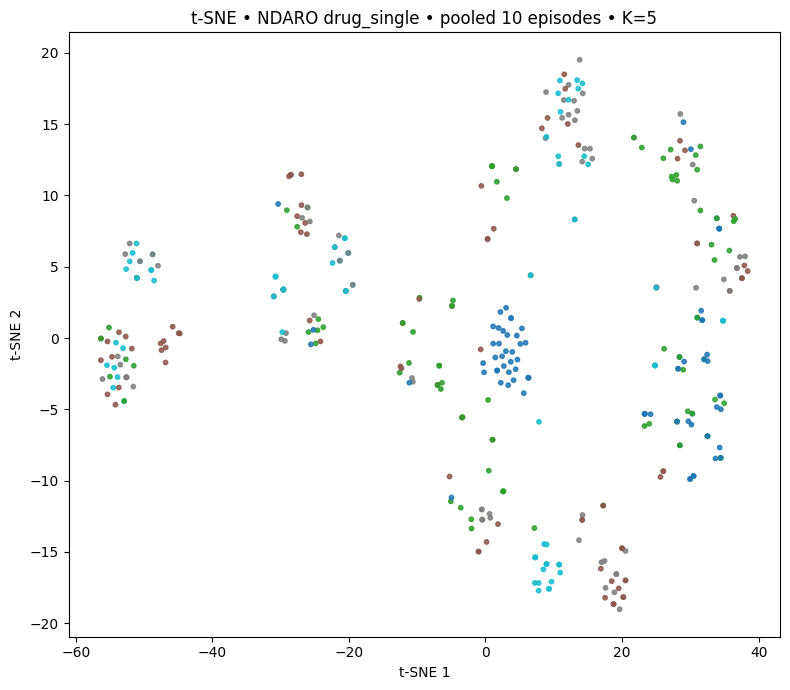


[6/6] Done!


In [ ]:
import os, re, json, math, random, numpy as np, pandas as pd
from pathlib import Path

LABEL_TARGET = "drug_class"
K_VALUES     = [1,3,5]
N, Q         = 5, 3
EPISODES     = 600
MAX_LEN      = 512
KMER_K       = 5

CATALOG_PATH     = "ReferenceGeneCatalog.txt"
HIERARCHY_PATH   = "ReferenceGeneHierarchy.txt"
FAM_PATH         = "fam.tsv"
FASTA_PATH       = "AMR_CDS.fa"

# pretrained assets from MEGARes run
CKPT_PATH = "best_metaoptnet_cnn.pt"
STOI_PATH = "stoi.json"
NUM_MEAN  = "num_mean.npy"
NUM_STD   = "num_std.npy"

def normalize_multi(x):
    parts = [p.strip() for p in str(x).replace("|",";").split(";") if p and p.strip()!="NA"]
    return "|".join(sorted(set(parts))) if parts else "NA"

DRUG_STRATEGY = "first"

def pick_drug_single(drug_str, strategy="first"):
    if drug_str is None or drug_str == "NA":
        return None
    toks = [t.strip() for t in drug_str.split("|") if t.strip()]
    if not toks: return None
    if strategy == "first":
        return toks[0]
    if strategy == "collapse_beta":
        beta = {"cephalosporin","penicillin","monobactam","carbapenem","beta-lactam"}
        if any(t in beta for t in toks): return "beta-lactam"
        return toks[0]
    return toks[0]

print("[1/6] Building label_map from NDARO files...")

catalog = pd.read_csv(CATALOG_PATH, sep="\t", dtype=str, engine="python")
catalog.columns = [c.strip().lower().replace(" ", "_") for c in catalog.columns]

catalog = catalog[["allele", "product_name", "class", "subclass", "hierarchy_node"]].copy()
catalog.columns = ["aro_accession", "aro_name", "class", "subclass", "hierarchy_node"]

catalog["drug_class"] = catalog.apply(
    lambda r: normalize_multi(f"{r['class']}|{r['subclass']}"), axis=1
)

hierarchy = pd.read_csv(HIERARCHY_PATH, sep="\t", dtype=str, engine="python")
hierarchy.columns = [c.strip().lower().replace(" ", "_") for c in hierarchy.columns]

mechanism_keywords = [
    "acetyltransferase", "phosphotransferase", "nucleotidyltransferase",
    "beta-lactamase", "metallo-beta-lactamase", "carbapenemase",
    "efflux", "transporter", "pump",
    "methyltransferase", "methylase",
    "mutation", "mutant",
    "ribosomal", "protection",
    "hydrolase", "synthase", "modifying"
]

def extract_mechanism(hier_name):
    if pd.isna(hier_name) or hier_name == "":
        return "NA"
    name_lower = str(hier_name).lower()
    for kw in mechanism_keywords:
        if kw in name_lower:
            return kw
    return "NA"

hierarchy["mechanism"] = hierarchy["name"].map(extract_mechanism)
hierarchy_mech = hierarchy[["node_id", "mechanism"]].copy()
hierarchy_mech.columns = ["hierarchy_node", "mechanism"]

fam = pd.read_csv(FAM_PATH, sep="\t", dtype=str, engine="python")
fam.columns = [c.strip().lower().replace("#", "").replace(" ", "_") for c in fam.columns]
fam = fam[["node_id", "family_name"]].copy()
fam.columns = ["hierarchy_node", "amr_gene_family"]

label_map = catalog.merge(hierarchy_mech, on="hierarchy_node", how="left")
label_map = label_map.merge(fam, on="hierarchy_node", how="left")

label_map["mechanism"] = label_map["mechanism"].fillna("NA")
label_map["amr_gene_family"] = label_map["amr_gene_family"].fillna("NA")

label_map = label_map[["aro_accession", "aro_name", "amr_gene_family", "drug_class", "mechanism", "hierarchy_node"]]
label_map.to_csv("label_map.csv", index=False)
print(f"[OK] Wrote label_map.csv  rows={len(label_map)}")

print("[2/6] Building seq_manifest.csv from FASTA...")

from Bio import SeqIO

rows = []
allele_samples = []
for i, rec in enumerate(SeqIO.parse(FASTA_PATH, "fasta")):
    parts = rec.description.split("|")

    if i < 5:
        allele_samples.append(rec.description)

    if len(parts) >= 7:
        # Try both field 5 and 6
        allele = parts[5].strip()  # Most likely the allele field
        if not allele or allele == "":
            allele = parts[6].strip()
    elif len(parts) >= 6:
        allele = parts[5].strip()
    else:
        continue

    rows.append({
        "seq_id": rec.id,
        "aro_accession": allele,
        "sequence": str(rec.seq).upper().replace("U","T"),
    })

print(f"[DEBUG] Sample FASTA headers (first 5):")
for sample in allele_samples[:5]:
    print(f"  {sample}")
print(f"[DEBUG] Extracted {len(rows)} sequences from FASTA")

man = pd.DataFrame(rows)
lm  = pd.read_csv("label_map.csv", dtype=str)

print(f"[DEBUG] label_map alleles (first 10): {lm['aro_accession'].head(10).tolist()}")
print(f"[DEBUG] FASTA alleles (first 10): {man['aro_accession'].head(10).tolist()}")
print(f"[DEBUG] Alleles in common: {len(set(man['aro_accession']) & set(lm['aro_accession']))}")

merged = man.merge(lm, on="aro_accession", how="inner")
print(f"[DEBUG] After merge: {len(merged)} sequences")
merged["sequence"] = merged["sequence"].str.replace(r"[^ACGT]", "", regex=True)
merged = merged[merged["sequence"].str.len() >= 50].copy()
merged["seq_len"] = merged["sequence"].str.len()
merged["gc_content"] = merged["sequence"].map(lambda s: (s.count("G")+s.count("C"))/len(s) if len(s)>0 else 0)

# make single-valued labels for the chosen target
if LABEL_TARGET == "drug_class":
    merged["drug_single"] = merged["drug_class"].map(lambda s: pick_drug_single(s, strategy=DRUG_STRATEGY))
    merged = merged[merged["drug_single"].notna()].copy()
    label_col = "drug_single"
else:
    # mechanism & amr_gene_family: take first token if multi
    def first_token(x):
        if pd.isna(x) or x == "NA":
            return None
        toks = [t.strip() for t in str(x).split("|") if t.strip() and t.strip() != "NA"]
        return toks[0] if toks else None
    merged[LABEL_TARGET] = merged[LABEL_TARGET].map(first_token)
    merged = merged[merged[LABEL_TARGET].notna()].copy()
    label_col = LABEL_TARGET

merged.to_csv("seq_manifest.csv", index=False)
print(f"[OK] Wrote seq_manifest.csv  rows={len(merged)}  label={label_col}")

# ---------------- 3) Make few-shot splits ----------------
print(f"[3/6] Creating few-shot splits for {label_col}...")

def make_splits(df, label, K, out_root, episodes=EPISODES, N=N, Q=Q, seed=42):
    np.random.seed(seed)
    counts = df[label].value_counts()
    labels = counts[counts >= (K + Q)].index.tolist()
    print(f"  K={K}: usable classes={len(labels)}")
    outK = out_root / f"K{K}"
    outK.mkdir(parents=True, exist_ok=True)
    for epi in range(episodes):
        if len(labels) < N: break
        picked = np.random.choice(labels, size=N, replace=False)
        S, Qr = [], []
        for lab in picked:
            cand = df[df[label]==lab]
            if len(cand) < (K + Q):
                continue
            idx = np.random.choice(cand.index, size=K+Q, replace=False)
            S.append(cand.loc[idx[:K], ["seq_id", label]])
            Qr.append(cand.loc[idx[K:], ["seq_id", label]])
        if len(S) == N:  # only save if we got all N classes
            epdir = outK / f"episode_{epi:04d}"
            epdir.mkdir(exist_ok=True, parents=True)
            pd.concat(S).to_csv(epdir/"support.csv", index=False)
            pd.concat(Qr).to_csv(epdir/"query.csv",   index=False)

df = pd.read_csv("seq_manifest.csv", dtype={"seq_len":float,"gc_content":float})
SPLITS_ROOT = f"splits_{label_col}"
Path(SPLITS_ROOT).mkdir(exist_ok=True)
print(f"[Splits] target={label_col}  root={SPLITS_ROOT}")
for K in K_VALUES:
    make_splits(df, label_col, K, Path(SPLITS_ROOT))

# ---------------- 4) Evaluate with your MEGARes encoder ----------------
print("[4/6] Loading model and running evaluation...")

import torch, torch.nn as nn, torch.nn.functional as F

with open(STOI_PATH) as f:
    stoi = json.load(f)
PAD, UNK = "", ""
pad_id = stoi.get(PAD, 0); unk_id = stoi.get(UNK, 1)
num_mean = np.load(NUM_MEAN); num_std = np.load(NUM_STD)

def kmers(seq, k=KMER_K):
    L = len(seq);
    return [seq[i:i+k] for i in range(L-k+1)] if L>=k else []

def encode_seq_ids(seq):
    toks = kmers(seq, KMER_K)
    if not toks: return [unk_id]
    return [stoi.get(t, unk_id) for t in toks]

def pad_ids(ids, max_len=MAX_LEN):
    out = np.full((max_len,), pad_id, dtype=np.int64)
    s = ids[:max_len]
    out[:len(s)] = s
    return out

class CNNSeqEncoder(nn.Module):
    def __init__(self, vocab_size, pad_idx, max_len,
                 embed_dim=256, token_dim=128,
                 conv_channels=96, kernel_sizes=(3,5,7),
                 use_cosine=True, num_features=2):
        super().__init__()
        self.use_cosine = use_cosine
        self.emb = nn.Embedding(vocab_size, token_dim, padding_idx=pad_idx)
        self.emb_dropout = nn.Dropout(0.20)
        self.convs = nn.ModuleList([
            nn.Sequential(
                nn.Conv1d(token_dim, conv_channels, k, padding=k//2),
                nn.ReLU(),
                nn.Dropout1d(0.10)
            ) for k in kernel_sizes
        ])
        self.num_proj = nn.Sequential(nn.Linear(num_features, 32), nn.ReLU(), nn.BatchNorm1d(32))
        fused_in = conv_channels*len(kernel_sizes)*2 + 32
        self.proj = nn.Sequential(nn.Linear(fused_in, 512), nn.ReLU(), nn.BatchNorm1d(512), nn.Dropout(0.50),
                                  nn.Linear(512, 256))
        self.log_temp = nn.Parameter(torch.zeros(1))
    def forward(self, tokens, nums):
        x = self.emb(tokens)
        x = self.emb_dropout(x).transpose(1,2)
        pooled = []
        for block in self.convs:
            h = block(x)
            pooled += [F.adaptive_max_pool1d(h,1).squeeze(-1),
                       F.adaptive_avg_pool1d(h,1).squeeze(-1)]
        h_text = torch.cat(pooled, dim=1)
        h_num  = self.num_proj(nums)
        z = self.proj(torch.cat([h_text, h_num], dim=1))
        return F.normalize(z, p=2, dim=1) if self.use_cosine else z

def ridge_logits(s_z, s_y, q_z, l2=1e-3):
    C = int(s_y.max().item())+1
    Y = F.one_hot(s_y, num_classes=C).float()
    A = s_z.t() @ s_z + l2*torch.eye(s_z.shape[1], device=s_z.device)
    B = s_z.t() @ Y
    W = torch.linalg.solve(A, B)
    return q_z @ W

manifest = pd.read_csv("seq_manifest.csv", dtype={"seq_len":float,"gc_content":float})
seq_by_id = manifest.set_index("seq_id").to_dict(orient="index")

def load_episode(ep_dir, label=label_col, device="cpu"):
    S = pd.read_csv(ep_dir/"support.csv")
    Q = pd.read_csv(ep_dir/"query.csv")
    labs = sorted(S[label].unique())
    lab2id = {l:i for i,l in enumerate(labs)}
    def pack(df):
        toks, nums, ys = [], [], []
        for _, r in df.iterrows():
            rec = seq_by_id[r["seq_id"]]
            ids = pad_ids(encode_seq_ids(rec["sequence"]), MAX_LEN)
            toks.append(ids)
            nums.append([rec["gc_content"], rec["seq_len"]])
            ys.append(lab2id[r[label]])
        toks = torch.tensor(np.stack(toks)).long().to(device)
        nums = torch.tensor((np.stack(nums)-num_mean)/(num_std+1e-6)).float().to(device)
        ys   = torch.tensor(ys).long().to(device)
        return toks, nums, ys
    return *pack(S), *pack(Q), labs

device = "cuda" if torch.cuda.is_available() else "cpu"
model = CNNSeqEncoder(vocab_size=len(stoi), pad_idx=pad_id, max_len=MAX_LEN).to(device)
ckpt = torch.load(CKPT_PATH, map_location=device)
res = model.load_state_dict(ckpt, strict=True)
print("[OK] Loaded encoder. Missing:", res.missing_keys, "Unexpected:", res.unexpected_keys)
model.eval()

print("\n" + "="*60)
print(f"NDARO Few-Shot Evaluation Results ({label_col})")
print("="*60)

for K in K_VALUES:
    ep_root = Path(SPLITS_ROOT)/f"K{K}"
    ep_dirs = sorted([p for p in ep_root.iterdir() if p.is_dir()])[:EPISODES]
    accs = []
    for ep in ep_dirs:
        s_tok, s_num, s_y, q_tok, q_num, q_y, _ = load_episode(ep, label=label_col, device=device)
        with torch.no_grad():
            s_z = model(s_tok, s_num)
            q_z = model(q_tok, q_num)
            logits = ridge_logits(s_z, s_y, q_z, l2=1e-3)
            pred = logits.argmax(dim=1)
            accs.append((pred==q_y).float().mean().item())
    accs = np.array(accs, float)
    print(f"[NDARO @ {label_col}] K={K}: acc={accs.mean():.3f} ± {accs.std():.3f} (n={len(accs)})")

# ---------------- t-SNE over 10 episodes ----------------
print("\n[5/6] Generating t-SNE visualization...")
DO_TSNE = True
if DO_TSNE:
    from sklearn.manifold import TSNE
    import matplotlib.pyplot as plt
    K_PICK = max(K_VALUES)
    root = Path(SPLITS_ROOT)/f"K{K_PICK}"
    eps = sorted([p for p in root.iterdir() if p.is_dir()])[:10]
    Zs, Ys = [], []
    for ep in eps:
        s_tok, s_num, s_y, q_tok, q_num, q_y, labs = load_episode(ep, label=label_col, device=device)
        with torch.no_grad():
            Zs.append(model(s_tok, s_num).cpu().numpy())
            Zs.append(model(q_tok, q_num).cpu().numpy())
            Ys.append(s_y.cpu().numpy()); Ys.append(q_y.cpu().numpy())
    X = np.vstack(Zs); y = np.concatenate(Ys)
    perpl = min(30, max(5, len(X)//4 - 1))
    X2 = TSNE(n_components=2, perplexity=perpl, random_state=42).fit_transform(X)
    plt.figure(figsize=(8,7))
    plt.scatter(X2[:,0], X2[:,1], c=y, s=10, cmap="tab10", alpha=0.85)
    plt.title(f"t-SNE • NDARO {label_col} • pooled 10 episodes • K={K_PICK}")
    plt.xlabel("t-SNE 1"); plt.ylabel("t-SNE 2"); plt.tight_layout(); plt.show()

print("\n[6/6] Done!")